In [1]:
"""
Dependency
----------
1. This notebook assumes that Anayzer has been executed and it byproducts 
   (e.g. performance dataframe) have been generated.

2. This module is essentially a "Analyzer-Part2"
"""
import pandas as pd 
from pandas import DataFrame, Series
import os
import numpy as np
from decimal import Decimal

import warnings
warnings.filterwarnings('ignore')  # action='once'

np.set_printoptions(precision=3)

%matplotlib inline

In [2]:
from analyzer import load_performance

cohort = 'hepatitis-c'
df_perf = load_performance(input_dir='result', cohort=cohort)
n_init = df_perf.shape[0]
print("> col(pd_perf): {}\n".format(df_perf.columns))

dfp = df_perf.loc[df_perf['mean'] > 0].sort_values(by=['mean', ])
for code, score in zip(dfp['code'], dfp['mean']):
    print(f"[{code}] -> {score}")

> dim(performance matrix): (733, 4)
> col(pd_perf): Index(['code', 'mean', 'std', 'n_pos'], dtype='object')

[54031] -> 0.0024231680443138936
[60855] -> 0.015580085791859676
[80614] -> 0.3337866494342828
[162503] -> 0.4389279624893436
[33498] -> 0.480278164116829
[661496] -> 0.49527913771706106
[355594] -> 0.5360553081272308
[385187] -> 0.6043056936435339
[80994] -> 0.6139330334832583
[322156] -> 0.6383333333333333
[461541] -> 0.6422222222222221
[205070] -> 0.6450980392156863
[7377] -> 0.6666858109186049
[146282] -> 0.6675034867503487
[384453] -> 0.6807532956685499
[38794] -> 0.6826666666666668
[31674] -> 0.6844444444444445
[196428] -> 0.6848484848484848
[122358] -> 0.705
[24695] -> 0.7335339351387495
[138016] -> 0.7339233038348082
[24661] -> 0.7346236559139785
[24687] -> 0.7351111111111109
[192955] -> 0.7368115942028985
[80143] -> 0.7375
[285452] -> 0.7401129943502824
[196592] -> 0.76
[52449] -> 0.7666666666666667
[724864] -> 0.7833333333333333
[823781] -> 0.7933333333333332
[51938] -

### Identify target LOINC codes

In [3]:
# some statistics
th_low, th_high = 0.50, 0.90
n_codes = df_perf.shape[0]
assert n_codes == n_init

################################################
target_codes = codes = df_perf['code'].values  # codes associated with a given cohort (e.g. hepatitis c)
codes_low_sz = df_perf.loc[df_perf['mean'] < 0]['code'].values
codes_scored = df_perf.loc[df_perf['mean'] >= 0]['code'].values # <<<<< 
codes_high_score = df_perf.loc[df_perf['mean'] >= th_high]['code'].values
codes_low_score = df_perf.loc[(df_perf['mean'] < th_high) & (df_perf['mean'] >= 0)]['code'].values
################################################
assert n_codes == len(codes_low_sz) + len(codes_scored)

r_low_sz = round( len(codes_low_sz)/(n_codes+0.0) * 100, 3)
r_scored = round( len(codes_scored)/(n_codes+0.0) * 100, 3)
r_high_score = round( len(codes_high_score)/(n_codes+0.0) * 100, 3)

print("1. Total number of codes: {} | n(low_sample): {}({}%), n(scored):{}({}%), n(high scored):{}({}%)".format(n_codes, 
   len(codes_low_sz), r_low_sz, len(codes_scored), r_scored, len(codes_high_score), r_high_score))
print("2. Pecentage scored codes: {}%".format(r_scored))
print("3. Percentage \"good\" codes: {}%".format(r_high_score))

# Effective performance dataframe, ruling out those codes without scores (due to low sample sizes)
df_eff = df_perf.loc[df_perf['mean'] >= 0.0]

# top N and low N
n_offset = 25
df_topn = df_eff.sort_values(['mean', ], ascending=False).head(n_offset)
df_botn = df_eff.sort_values(['mean', ], ascending=True).head(n_offset)

################################################
# key vars: 
#   target_codes, codes_scored, codes_low_sz, codes_high_score, codes_low_score


1. Total number of codes: 733 | n(low_sample): 273(37.244%), n(scored):460(62.756%), n(high scored):386(52.66%)
2. Pecentage scored codes: 62.756%
3. Percentage "good" codes: 52.66%


## Inspect Loinc Table

In [4]:
from analyzer import sample_loinc_table

cols_inspect = []
adict = sample_loinc_table(codes=target_codes, cols=cols_inspect, n_samples=10, verbose=1)

> dim(table): (92369, 46)
[1] loinc: 134577:
  - LOINC_NUM: 134577
  - COMPONENT: Cholesterol.in LDL
  - PROPERTY: MCnc
  - TIME_ASPCT: Pt
  - SYSTEM: Ser/Plas
  - SCALE_TYP: Qn
  - METHOD_TYP: Calculated
  - CLASS: CHEM
  - VersionLastChanged: 2.40
  - CHNG_TYPE: MIN
  - DefinitionDescription: nan
  - STATUS: ACTIVE
  - CONSUMER_NAME: nan
  - CLASSTYPE: 1
  - FORMULA: Total cholesterol - HDL - (Triglyceride/5)
  - SPECIES: nan
  - EXMPL_ANSWERS: nan
  - SURVEY_QUEST_TEXT: nan
  - SURVEY_QUEST_SRC: nan
  - UNITSREQUIRED: Y
  - SUBMITTED_UNITS: nan
  - RELATEDNAMES2: Calc; Calculation; Chemistry; Chol; Choles; Cholest; Cholesterol total; Cholesterols; LDLc; LDL-C; Level; Lipid; Low density lipoprotein cholesterol; Low density lipoprotein cholesterols; Mass concentration; Pl; Plasma; Plsm; Point in time; QNT; Quan; Quant; Quantitative; Random; SerP; SerPl; SerPlas; Serum; Serum or plasma; SR
  - SHORTNAME: LDLc SerPl Calc-mCnc
  - ORDER_OBS: Observation
  - CDISC_COMMON_TESTS: nan
  - HL

### Load LOINC Table(s)

In [5]:
from analyzer import load_loinc_table, sample_loinc_table
from transformer import dehyphenate

"""
Key features  
   LONG_COMMON_NAME
   SHORTNAME
    
   RELATEDNAMES2
   STATUS_TEXT

"""

def label_as(lv, i, s='easy', codebook={'easy': 1, 'hard': 0}): 
    lv[i] = codebook[s]
    return
        
labels = ['easy', 'hard']
col_code = 'LOINC_NUM'
cols_target = "COMPONENT, PROPERTY, TIME_ASPCT, SYSTEM, METHOD_TYP, SCALE_TYP"  # CLASS
cols_6p = ["COMPONENT","PROPERTY","TIME_ASPCT","SYSTEM","SCALE_TYP","METHOD_TYP"]   # CLASS
codebook = {'easy': 1, 'hard': 0}

# load LOINC table
df_loinc = load_loinc_table()
print("> col(Loinc Table):\n{}\n".format(list(df_loinc.columns.values)))

fset = cols_6p # cols_6p = [col.strip() for col in cols_target.split(',')]
# assert sum(1 for col in cols_6p if not col in df_loinc.columns) == 0  # ... ok

dehyphenate(df_loinc, col=col_code)  # inplace
# assert sum(1 for code in df_loinc[col_code] if code.find('-') >= 0) == 0  # ... ok

codes_src = set(df_loinc[col_code].values)
n_codes_missed = 0
dfx = []

levels = [] # np.zeros(len(target_codes), dtype=int) # .astype(int)
codes_eff = [] 
codes_missed = []
for i, code in enumerate(target_codes): 
    if code in codes_src: 
        codes_eff.append(code) # codes with the desired feature represenation (e.g. 6 parts)
        
        row = df_loinc.loc[df_loinc[col_code] == code][cols_6p]
        assert row.shape[0] == 1, "multiple rows? {}".format(row)
        dfx.append(row) # note: 'df_loinc[col_code] == code' returns a sliced dataframe
        
        # labeling
        if code in codes_high_score: 
            # label_as(levels, i, 'easy')
            levels.append('easy') # codebook['easy']
        else: 
            levels.append('hard') # codebook['hard']
            
    else: 
        n_codes_missed += 1
        codes_missed.append(code)
        
df = pd.concat(dfx, ignore_index=True)
df['label'] = levels   # <<< label
df['y'] = [codebook[level] for level in levels]
df['code'] = codes_eff

msg = "> dim(df: six_parts): {}\n".format(df.shape)
msg += f"> # codes not found in loinc table: {n_codes_missed}\n"

print(msg)
print(df.sample(10))

################################################################################


> dim(table): (92369, 46)
> col(Loinc Table):
['LOINC_NUM', 'COMPONENT', 'PROPERTY', 'TIME_ASPCT', 'SYSTEM', 'SCALE_TYP', 'METHOD_TYP', 'CLASS', 'VersionLastChanged', 'CHNG_TYPE', 'DefinitionDescription', 'STATUS', 'CONSUMER_NAME', 'CLASSTYPE', 'FORMULA', 'SPECIES', 'EXMPL_ANSWERS', 'SURVEY_QUEST_TEXT', 'SURVEY_QUEST_SRC', 'UNITSREQUIRED', 'SUBMITTED_UNITS', 'RELATEDNAMES2', 'SHORTNAME', 'ORDER_OBS', 'CDISC_COMMON_TESTS', 'HL7_FIELD_SUBFIELD_ID', 'EXTERNAL_COPYRIGHT_NOTICE', 'EXAMPLE_UNITS', 'LONG_COMMON_NAME', 'UnitsAndRange', 'EXAMPLE_UCUM_UNITS', 'EXAMPLE_SI_UCUM_UNITS', 'STATUS_REASON', 'STATUS_TEXT', 'CHANGE_REASON_PUBLIC', 'COMMON_TEST_RANK', 'COMMON_ORDER_RANK', 'COMMON_SI_TEST_RANK', 'HL7_ATTACHMENT_STRUCTURE', 'EXTERNAL_COPYRIGHT_LINK', 'PanelType', 'AskAtOrderEntry', 'AssociatedObservations', 'VersionFirstReleased', 'ValidHL7AttachmentRequest', 'DisplayName']

> dim(df: six_parts): (722, 9)
> # codes not found in loinc table: 11

                                     COMPONENT

### Target LOINC Codes Summary

In [6]:
print("> 1. Codes not found in LOINC table (n={})".format(len(codes_missed)))
for code in codes_missed: 
    print("  + {}".format(code))
print('-' * 50 + '\n')

# find codes not found in the standard LOINC table via MapTo.csv
df_mapto = load_loinc_table(input_dir='LoincTable', input_file='MapTo.csv', sep=',') 
# ... cols: "LOINC" (Obsolete LNC code),"MAP_TO" (current code),"COMMENT"

dehyphenate(df_mapto, col=['LOINC', 'MAP_TO'])  # inplace
codes_old = df_mapto['LOINC'].values
codes_new = df_mapto['MAP_TO'].values

nM = nO = nN =0
for code in codes_missed: 
    if code in codes_old: 
        print("!!! {} found in obsolete set".format(code))
        nO += 1
    if code in codes_new: 
        print("!!! {} found in mapped to set (current)".format(code))
        nN += 1
nM = nO + nN
print(f"!!! {nM} missing cases found in MapTo ... #")

################################################################################

text_cols = ['LONG_COMMON_NAME', 'SHORTNAME', 'RELATEDNAMES2', 'STATUS_TEXT']
property_cols = cols_6p + ['CLASS'] # ["COMPONENT","PROPERTY","TIME_ASPCT","SYSTEM","SCALE_TYP","METHOD_TYP"] 
select_cols = [col_code, ] + text_cols + property_cols

codes_easy = df.loc[df['label'] == 'easy'][ 'code' ].values
codes_hard = df.loc[df['label'] == 'hard'][ 'code' ].values

# print("> col(df_loincs): {}".format(df_loinc.columns.values))
df_codes_easy = df_loinc.loc[df_loinc[col_code].isin(codes_easy)][select_cols]
df_codes_hard = df_loinc.loc[df_loinc[col_code].isin(codes_hard)][select_cols]

print("> 2.1 Easy cases (n={}) ".format(len(codes_easy)))
for r, row in df_codes_easy.iterrows():
    code = row[col_code]
    p6 = [row['COMPONENT'], row['PROPERTY'], row['TIME_ASPCT'], row['SYSTEM'], row['METHOD_TYP'], row['SCALE_TYP'], row['CLASS']]
    six_parts = ': '.join(str(e) for e in p6)
    print("[{}] {} (6p: {}) =>\n ... {}\n".format(r+1, code, six_parts, row['LONG_COMMON_NAME']))
    
print("> 2.2 Hard cases (n={}) ".format(len(codes_hard)))
for r, row in df_codes_hard.iterrows():
    code = row[col_code]
    p6 = [row['COMPONENT'], row['PROPERTY'], row['TIME_ASPCT'], row['SYSTEM'], row['METHOD_TYP'], row['SCALE_TYP'], row['CLASS']]
    six_parts = ': '.join(str(e) for e in p6)
    print("[{}] {} (6p: {}) =>\n ... {}\n".format(r+1, code, six_parts, row['LONG_COMMON_NAME']))

# perhaps the missed codes are older codes, which have been mapped to new codes (MapTo.csv)

> 1. Codes not found in LOINC table (n=11)
  + 80100
  + 17435
  + 882934
  + 005025
  + 99006
  + 550513
  + unknown
  + 75007
  + 5056360
  + 30741
  + 84999
--------------------------------------------------

> dim(table): (3544, 3)
!!! 0 missing cases found in MapTo ... #
> 2.1 Easy cases (n=382) 
[519] 104661 (6p: Anion gap 3: SCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Anion gap 3 in Serum or Plasma

[927] 108340 (6p: Globulin: MCnc: Pt: Ser: Calculated: Qn: CHEM) =>
 ... Globulin [Mass/volume] in Serum by calculation

[985] 108860 (6p: Prostate specific Ag.free: MCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Prostate Specific Ag Free [Mass/volume] in Serum or Plasma

[1002] 109009 (6p: Hepatitis B virus surface Ab: PrThr: Pt: Ser: IA: Ord: MICRO) =>
 ... Hepatitis B virus surface Ab [Presence] in Serum by Immunoassay

[1124] 110114 (6p: Hepatitis C virus RNA: ACnc: Pt: Ser/Plas: Probe.amp.tar: Qn: MICRO) =>
 ... Hepatitis C virus RNA [Units/volume] (viral load) in Serum or Plasma by 

### Variable Properties

In [7]:
from analyzer import det_cardinality, det_cardinality2
from transformer import encode_vars

# fill in missing values (also see default_values)
token_missing = "-" 

# missing_default = {"PROPERTY": token_missing,  # nc = 49, 
#                    "TIME_ASPCT": '*',                    
# }

df.fillna(value=token_missing, inplace=True)

print("> Before variable encoding: dim(df): {}\n> Header: {}".format(df.shape, df.columns[:100]))
print(df.sample(10)); print('-' * 50 + '\n')

# determine cardinality 
# card = det_cardinality(df, th_card=10, cols=fset, verbose=1)
# ... if >= th_card, consider as high-cardinality categorical vas
# ... card: var -> {True, False}, True if high card

card = det_cardinality2(df, th_card=10, cols=fset, verbose=1)
high_card_cols = card['high_card']

# print(card) # car

> Before variable encoding: dim(df): (722, 9)
> Header: Index(['COMPONENT', 'PROPERTY', 'TIME_ASPCT', 'SYSTEM', 'SCALE_TYP',
       'METHOD_TYP', 'label', 'y', 'code'],
      dtype='object')
                                        COMPONENT PROPERTY TIME_ASPCT  \
430                                     Cells.CD3     NCnc         Pt   
226                                   Nordiazepam     MCnc         Pt   
507                      Monocytes/100 leukocytes      NFr         Pt   
241  Ribonucleoprotein extractable nuclear Ab.IgG     ACnc         Pt   
330                                     Thyroxine     MCnc         Pt   
515                            Apolipoprotein A-I     MCnc         Pt   
166                               Benzodiazepines    PrThr         Pt   
620                         Hepatitis C virus RNA     ACnc         Pt   
648                           Bacteria identified     Prid         Pt   
610                                    Leukocytes     NCnc         Pt   

     

### Data Curation (missing value + variable encoding)

In [8]:
from transformer import categorify 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

cat_cols = cols_6p
cont_cols = []
# df = encode_vars(df, high_card_cols=high_card_cols, fset=cat_cols)

encoding_mode = 1

if encoding_mode in (1, 'binary'): 
    # use binary ecoder for all vars
    df = encode_vars(df, high_card_cols=cat_cols, fset=cat_cols) 
elif encoding_mode in (2, ):
    df = categorify(df, cat_cols=cat_cols)
    
print("> After variable encoding: dim(df): {}\n> Header: {}".format(df.shape, df.columns[:100]))
print(df.sample(10))


(encoder_vars) low card vars (n=[]):
0
 ... high card vars (n=['COMPONENT', 'PROPERTY', 'TIME_ASPCT', 'SYSTEM', 'SCALE_TYP', 'METHOD_TYP']):
6

... transforming var: COMPONENT ...
... transforming var: PROPERTY ...
... transforming var: TIME_ASPCT ...
... transforming var: SYSTEM ...
... transforming var: SCALE_TYP ...
... transforming var: METHOD_TYP ...
> After variable encoding: dim(df): (722, 40)
> Header: Index(['COMPONENT_0', 'COMPONENT_1', 'COMPONENT_2', 'COMPONENT_3',
       'COMPONENT_4', 'COMPONENT_5', 'COMPONENT_6', 'COMPONENT_7',
       'COMPONENT_8', 'COMPONENT_9', 'PROPERTY_0', 'PROPERTY_1', 'PROPERTY_2',
       'PROPERTY_3', 'PROPERTY_4', 'PROPERTY_5', 'PROPERTY_6', 'TIME_ASPCT_0',
       'TIME_ASPCT_1', 'TIME_ASPCT_2', 'SYSTEM_0', 'SYSTEM_1', 'SYSTEM_2',
       'SYSTEM_3', 'SYSTEM_4', 'SYSTEM_5', 'SCALE_TYP_0', 'SCALE_TYP_1',
       'SCALE_TYP_2', 'SCALE_TYP_3', 'METHOD_TYP_0', 'METHOD_TYP_1',
       'METHOD_TYP_2', 'METHOD_TYP_3', 'METHOD_TYP_4', 'METHOD_TYP_5',
      

## Error Analysis (Part I)

### Visualizing LOINC: PCA

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# %matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

print("> all columns (n={}):\n{}\n".format(df.shape[1], df.columns))
non_feature_cols = ['code', 'label', 'y']
# X = df.drop(non_feature_cols, axis=1).values

# determine X
####################################
if encoding_mode in (1, 'binary', ): 
    X = df.drop(non_feature_cols, axis=1).values
    
elif encoding_mode in (2, ): 
    X_cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
    # X_conts = np.stack([df[col].values for col in cont_cols], 1)
    
    nf = X_cats.shape[1] # + X_conts.shape[1]
    print("> Using n={} features ... #".format(nf))

    # X = np.hstack([X_cats, X_conts])
    X = X_cats
    
    print("> X: {}".format(X[:10, :]))
    
    # feature scaling
    scaler = MinMaxScaler() # MinMaxScaler(), StandardScaler()
    X = scaler.fit_transform(X)
    
    # print("> X: {}".format(X[:10, :]))
####################################

# determine y
y = df['y'].values
print("> dim(X): {}, dim(y): {}".format(X.shape, y.shape))

# cell output: (X, y)

> all columns (n=40):
Index(['COMPONENT_0', 'COMPONENT_1', 'COMPONENT_2', 'COMPONENT_3',
       'COMPONENT_4', 'COMPONENT_5', 'COMPONENT_6', 'COMPONENT_7',
       'COMPONENT_8', 'COMPONENT_9', 'PROPERTY_0', 'PROPERTY_1', 'PROPERTY_2',
       'PROPERTY_3', 'PROPERTY_4', 'PROPERTY_5', 'PROPERTY_6', 'TIME_ASPCT_0',
       'TIME_ASPCT_1', 'TIME_ASPCT_2', 'SYSTEM_0', 'SYSTEM_1', 'SYSTEM_2',
       'SYSTEM_3', 'SYSTEM_4', 'SYSTEM_5', 'SCALE_TYP_0', 'SCALE_TYP_1',
       'SCALE_TYP_2', 'SCALE_TYP_3', 'METHOD_TYP_0', 'METHOD_TYP_1',
       'METHOD_TYP_2', 'METHOD_TYP_3', 'METHOD_TYP_4', 'METHOD_TYP_5',
       'METHOD_TYP_6', 'label', 'y', 'code'],
      dtype='object')

> dim(X): (722, 37), dim(y): (722,)


In [10]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1] 
df['pca3'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

print('> n(labels): {}'.format(len(np.unique(y))))

Explained variation per principal component: [0.14  0.077 0.076]
> n(labels): 2


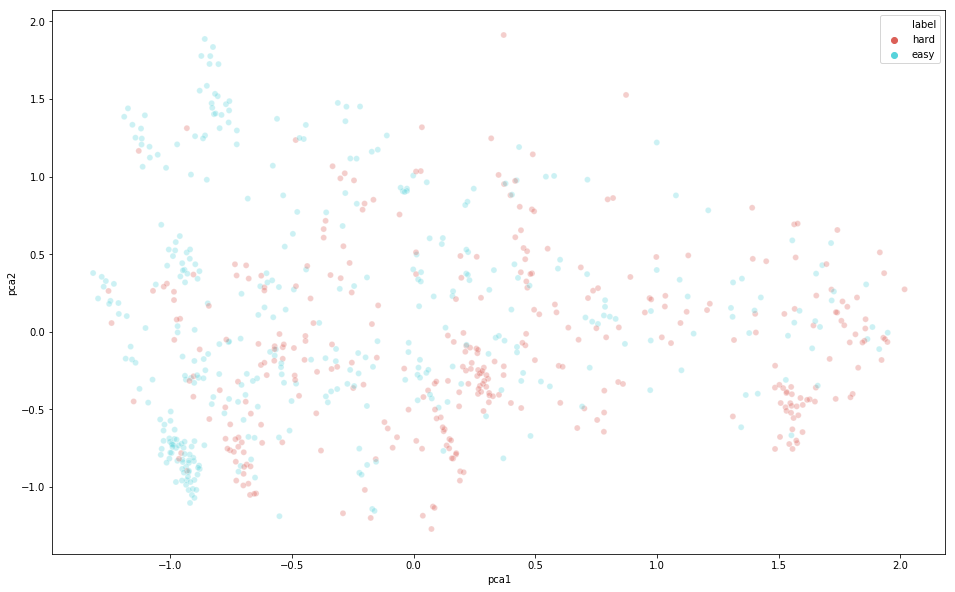

In [11]:
n_colors = 2  # len(labels)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca1", y="pca2",
    hue="label",
    palette=sns.color_palette("hls", n_colors),
    data=df.loc[rndperm,:],   # redundant here
    legend="full",
    alpha=0.3
)

### Visualizing LOINC: t-SNE

In [12]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 722 samples in 0.001s...
[t-SNE] Computed neighbors for 722 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 722 / 722
[t-SNE] Mean sigma: 0.891421
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.718803
[t-SNE] Error after 300 iterations: 1.452668
t-SNE done! Time elapsed: 3.220597982406616 seconds


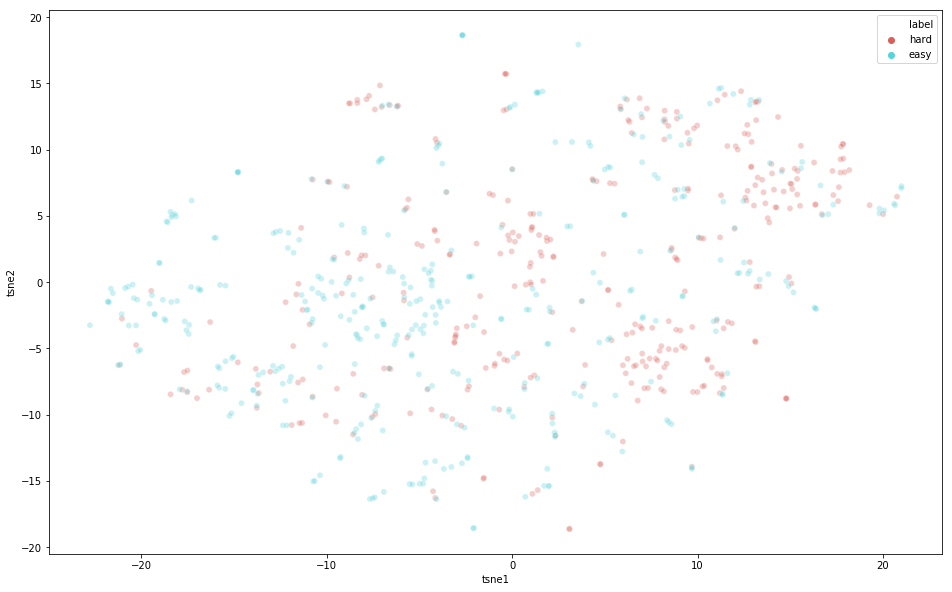

In [13]:
df['tsne1'] = tsne_results[:,0]
df['tsne2'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

# note: requires seaborn-0.9.0
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="label",
    palette=sns.color_palette("hls", n_colors),
    data=df,
    legend="full",
    alpha=0.3
)


### Error Analysis Part II

In [14]:
# {easy, hard} vs medivo test result type (MTRT)
from analyzer import label_by_performance, analyze_by_values, load_data
"""
Memo
----
   df: 6-parts training data
   codes_easy = df.loc[df['label'] == 'easy'][ 'code' ].values
   codes_hard = df.loc[df['label'] == 'hard'][ 'code' ].values

"""
cohort = 'hepatitis-c'

categories = ['easy', 'hard', 'low']  # low: low sample size
ccmap = label_by_performance(cohort='hepatitis-c', categories=categories)
assert len(ccmap) == len(categories), "n(ccmap): {} <> n(cat): {}".format(len(ccmap), len(categories))

# a dictionary of LOINC table dataframes indexed by analysis categories (e.g. easy, hard)
D = analyze_by_values(ccmap, verbose=0) # 
print("> key(D): {}".format(D.keys()))

# easy cases
df0 = D['easy']
df1 = D['hard']
df2 = D['low']
# ... ['LOINC_NUM' 'LONG_COMMON_NAME' 'SHORTNAME' 'RELATEDNAMES2' 
# ...  'STATUS_TEXT' 'PROPERTY' 'TIME_ASPCT' 'SYSTEM' 'METHOD_TYP' 'SCALE_TYP' 'CLASS']

# [todo] somehow the following assertion is not always true! 
# for cat in categories: 
#     assert len(ccmap[cat]) == D[cat].shape[0], "{} <> {}".format(len(ccmap[cat]), D[cat].shape[0])

col_key = 'LOINC_NUM'
cohort = 'hepatitis-c'
print("> col(df_easy): {} | dim(df0): {}".format(df0.columns.values, df0.shape))
codes_src = load_loinc_table(dehyphenate=True)['LOINC_NUM'].values 
codes_target = load_performance(input_dir='result', cohort=cohort)['code'].values

codes_easy = df0[col_key].values
codes_hard = df1[col_key].values 
codes_low =  df2[col_key].values
codes_missed = list(set(codes_target)-set(codes_src))
print("> n(easy): {}, n(hard): {}, n(low): {}".format(len(codes_easy), len(codes_hard), len(codes_low)))
print("> n(missed): {}".format(len(codes_missed)))
      
#####################################################################
# Total number of codes: 733 | n(low_sample): 273(37.244%), n(scored):460(62.756%), n(high scored):386(52.66%)

> dim(performance matrix): (733, 4)
(label_by_performance) dim(df_perf): (733, 4)
1. Total number of codes: 733 | n(low_sample): 273(37.244%), n(scored):460(62.756%), n(high scored):386(52.66%)
2. Pecentage scored codes: 62.756%
3. Percentage "good" codes: 52.66%
> dim(table): (92369, 46)
> key(D): dict_keys(['easy', 'hard', 'low'])
> col(df_easy): ['LOINC_NUM' 'LONG_COMMON_NAME' 'SHORTNAME' 'RELATEDNAMES2' 'STATUS_TEXT'
 'COMPONENT' 'PROPERTY' 'TIME_ASPCT' 'SYSTEM' 'SCALE_TYP' 'METHOD_TYP'
 'CLASS'] | dim(df0): (382, 12)
> dim(table): (92369, 46)
> dim(performance matrix): (733, 4)
> n(easy): 382, n(hard): 73, n(low): 267
> n(missed): 11


#### Error Analysis II: EDA

In [18]:
def has_null(df, cols=['test_result_name', 'test_result_value', ]): 
    for col in cols: 
        if df[col].isnull().values.any(): 
            return True
    return False
def subset_by_null(df, cols=['test_result_name', 'test_result_value', ]): 
    tvals = np.array([True] * df.shape[1])
    for i, col in enumerate(cols): 
    
        if i == 0: 
            tvals = df[col].isnull().values
        else: 
            tvals = np.logical_or(tvals, df[col].isnull().values)
            
    if np.sum(tvals) > 0: 
        return df[tvals]
    return DataFrame()  # dummy

from loinc import make_6p

# MTRT dataframe / training data
df = load_data(cohort=cohort, verbose=1)  # the original training data with relevant MTRT attributes
N0 = df.shape[0]

# drop duplicates # e.g. df.drop_duplicates(subset=['launched', 'code'], keep='last')
df = df.drop_duplicates(keep='last')  
N = df.shape[0]
print(f"> Drop dup | n(before): {N0} >? n(after): {N}")

# ... ['test_order_code' 'test_order_name' 'test_result_code' 'test_result_name' 'test_result_value' 
# ...  'test_result_range' ... ]
print("> col(df): {}\n".format(df.columns.values))
col_key_mtrt = 'test_result_loinc_code'

col_key = 'LOINC_NUM'
n_to_process = 0
tShowAll = False
for cat in ['hard', 'low']: 
    
    print(f"> Inspecting '{cat}' codes")
    dfl = D[cat]
    codes = dfl[col_key].values
    for i, code in enumerate(codes): # foreach code found in the loinc table
        ieff = i+1
        
        # 6 parts 
        six_parts = make_6p(dfl, code)
        
        # find its corresponding patient attributes in the original training data
        dfe = df.loc[df[col_key_mtrt] == code] 
        
        # find the sample size (n_pos)
        N = df_perf[df_perf['code'] == code]['n_pos'].iloc[0]  # ['code', 'mean', 'std', 'n_pos']

        msg = ""
        if tShowAll or has_null(dfe, cols=['test_result_name', 'test_result_value', 'medivo_test_result_type']): 
            
            n0 = dfe.shape[0]
            dfe = subset_by_null(dfe, cols=['test_result_name', 'test_result_value', 'medivo_test_result_type'])
            n = dfe.shape[0]
            print("> n(matched): {} -> {}".format(n0, n))  # this is usually > 1
            
            if n > 0: 
                dfe = dfe.sample(n=min(2, n))

                msg += "[{}] {} (N={}) => \n".format(ieff, code, N)
                msg += "    + 6 parts:          {}\n".format(six_parts)
                msg += "    + test_order_code:  {}\n".format(dfe['test_order_code'].values)
                msg += "    + test_order_name:  {}\n".format(dfe['test_order_name'].values)
                # msg += "    + test_result_code: {}\n".format(dfe['test_result_code'].values)
                msg += "    + test_result_name: {}\n".format(dfe['test_result_name'].values)
                msg += "    + test_result_value: {}\n".format(dfe['test_result_value'].values)
                
                msg += "-" * 50 + '\n'
                if 'test_result_comments' in dfe.columns: 
                    msg += "    + test_result_comments: {}\n".format(dfe['test_result_comments'].values)
                msg += "    + medivo_test_result_type: {}\n".format(dfe['medivo_test_result_type'].values)
                print(msg)
                

(load_data) Loaded dataframe (dim=(142366, 21)) from:
/Users/barnett/Documents/work/loinc_predictor/data/ts-hepatitis-c.csv

> Drop dup | n(before): 142366 >? n(after): 140952
> col(df): ['age' 'patient_gender' 'patient_state' 'patient_bill_type' 'fasting'
 'test_result_status' 'test_order_code' 'test_order_name'
 'test_result_code' 'test_result_name' 'test_result_value'
 'test_result_range' 'test_result_abnormal_flag'
 'test_result_reference_range' 'test_result_units_of_measure'
 'test_result_comments' 'test_cpt_code' 'panel_order_code'
 'panel_order_name' 'medivo_test_result_type' 'test_result_loinc_code']

> Inspecting 'hard' codes
> n(matched): 6 -> 5
[10] 142778 (N=5) => 
    + 6 parts:          Neutrophil cytoplasmic Ab.classic|Titr|Pt|Ser|Qn|IF
    + test_order_code:  ['201393' '162388']
    + test_order_name:  ['C ANCA+P ANCA' 'Antineutrophil Cytoplasmic Ab']
    + test_result_name: ['Cytoplasmic (C-ANCA)' 'Cytoplasmic (C-ANCA)']
    + test_result_value: ['0' '0']
-------------

> n(matched): 2 -> 2
[27] 142729 (N=1) => 
    + 6 parts:          Liver kidney microsomal Ab|PrThr|Pt|Ser|Ord|nan
    + test_order_code:  ['4682' '4682']
    + test_order_name:  ['LKM ANTIBODY' 'LKM ANTIBODY']
    + test_result_name: ['LKM ANTIBODY' 'LKM ANTIBODY']
    + test_result_value: ['1.1' '1.7']
--------------------------------------------------
    + test_result_comments: ['Interpretation: Negative  TESTING PERFORMED AT WARDE MEDICAL LABORATORY  300 WEST TEXTILE ROAD ANN ARBOR, MI 48108  CLIA NUMBER 23D0650611'
 'Interpretation: Negative  TESTING PERFORMED AT WARDE MEDICAL LABORATORY  300 WEST TEXTILE ROAD ANN ARBOR, MI 48108  CLIA NUMBER 23D0650611']
    + medivo_test_result_type: [nan nan]

> n(matched): 2 -> 2
[34] 150748 (N=2) => 
    + 6 parts:          Glucose|SCnc|Pt|Bld|Qn|nan
    + test_order_code:  ['2404' '2404']
    + test_order_name:  ['Comp. Metabolic Profile - Random (CMP)' 'Comp. Metabolic Panel (Random)']
    + test_result_name: ['Glucose' 'Glucose']
    + te

> n(matched): 2 -> 2
[110] 305524 (N=1) => 
    + 6 parts:          Pyridoxal phosphate|MCnc|Pt|Ser/Plas|Qn|nan
    + test_order_code:  ['SE745' '10801']
    + test_order_name:  ['VITAMIN B6 PLASMA' 'Special Female 18-45 Profile # 10801']
    + test_result_name: ['VITAMIN B6 PLASMA' 'VITAMIN B6']
    + test_result_value: ['21' 'TNP']
--------------------------------------------------
    + test_result_comments: ['This test was developed and its performance characteristics determined by Sonic Reference Laboratory (SRL). It has not been cleared or approved by the U.S. Food and Drug Administration (FDA). The FDA has determined that such clearance or approval is not necessary. This test is used for clinical purposes and should not be regarded as investigational or for research. SRL is qualified to perform high complexity testing under the Clinical Laboratory Improvement Amendments (CLIA).'
 'NO SPECIMEN RECEIVED.']
    + medivo_test_result_type: [nan nan]

> n(matched): 1 -> 1
[112] 312900

> n(matched): 1 -> 1
[152] 451765 (N=2) => 
    + 6 parts:          HIV nonnucleoside reverse transcriptase gene mutations detected|Prid|Pt|Isolate|Nom|nan
    + test_order_code:  ['4806']
    + test_order_name:  ['HIV-1 GENOTYPE RT-PCR/SEQUENCING']
    + test_result_name: ['NNRTI CLASS MUT ID']
    + test_result_value: ['Indeterminate']
--------------------------------------------------
    + test_result_comments: [nan]
    + medivo_test_result_type: [nan]

> n(matched): 2 -> 2
[153] 452243 (N=3) => 
    + 6 parts:          Mycoplasma pneumoniae Ab.IgG|PrThr|Pt|Ser|Ord|IA
    + test_order_code:  ['SRE145' 'E145']
    + test_order_name:  ['Mycoplasma Pneumoniae IgG' 'MYCOPLASMA PNEUMO IGG']
    + test_result_name: ['Mycoplasma Pneumoniae Antibody, IgG' 'M. pneumoniae Ab IgG']
    + test_result_value: ['1.20' '2.53']
--------------------------------------------------
    + test_result_comments: ['Suggestive of current or past M. pneumoniae infection.  Mycoplasma pneumoniae IgG may be de

> n(matched): 1 -> 1
[221] 71001 (N=1) => 
    + 6 parts:          Asparagus officinalis Ab.IgG|ACnc|Pt|Ser|Qn|nan
    + test_order_code:  ['81000.Z22']
    + test_order_name:  ['Drug Screen with Alcohol, Urine']
    + test_result_name: ['MDMA (Ecstasy)']
    + test_result_value: ['None Detected']
--------------------------------------------------
    + test_result_comments: ['Threshold Level (500 ng/mL) Unconfirmed, must not be used for -*- non-medical purposes. Confirmation of positive results done upon -*- request.']
    + medivo_test_result_type: [nan]

> n(matched): 3 -> 3
[223] 717744 (N=2) => 
    + 6 parts:          Mitogen stimulated gamma interferon^^corrected for background|ACnc|Pt|Bld|Qn|nan
    + test_order_code:  ['4136970954' '7505']
    + test_order_name:  ['QUANTIFERON(R)-TB GOLD PLUS, 1 TUBE' 'QUANTIFERON TB GOLD']
    + test_result_name: ['MITOGEN-NIL' 'NIL']
    + test_result_value: ['>10.00' '0.02']
--------------------------------------------------
    + test_resu

#### Error Analysis: Rule-based Predictor